# 8. Prediction Intervals for Data Streams

* This notebook covers how to utilise prediction intervals for regression tasks in CapyMOA.
* Two methods for obtaining prediction intervals are currently available in CapyMOA: MVE and AdaPI.

More details about prediction intervals for streaming data can be found in the AdaPI paper: 

[Yibin Sun, Bernhard Pfahringer, Heitor Murilo Gomes & Albert Bifet. "Adaptive Prediction Interval for Data Stream Regression." Pacific-Asia Conference on Knowledge Discovery and Data Mining. Springer, 2024.](https://link.springer.com/chapter/10.1007/978-981-97-2259-4_10)

---

*More information about CapyMOA can be found at* https://www.capymoa.org.

**last updated on 28/11/2025**

In [1]:
from capymoa.datasets import Fried

# load data
fried_stream = Fried()

## 8.1 Basic prediction interval usage

* Here is an example of prediction intervals in CapyMOA.
* Currently available prediction interval learners require a regressor base model.

In [2]:
from capymoa.regressor import SOKNL
from capymoa.prediction_interval import MVE

# build prediction interval learner in regular manner
soknl = SOKNL(schema=fried_stream.get_schema(), ensemble_size=10)
mve = MVE(schema=fried_stream.get_schema(), base_learner=soknl)

# build prediction interval learner in in-line manner
mve_inline = MVE(
    schema=fried_stream.get_schema(),
    base_learner=SOKNL(schema=fried_stream.get_schema(), ensemble_size=10),
)

## 8.2 Creating evaluators

* There are currently two types of prediction interval evaluators implemented: basic (cumulative) and windowed.

In [3]:
from capymoa.evaluation.evaluation import (
    PredictionIntervalEvaluator,
    PredictionIntervalWindowedEvaluator,
)

# build prediction interval (basic and windowed) evaluators
mve_evaluator = PredictionIntervalEvaluator(schema=fried_stream.get_schema())
mve_windowed_evaluator = PredictionIntervalWindowedEvaluator(
    schema=fried_stream.get_schema(), window_size=1000
)

## 8.3 Running test-then-train/prequential tasks manually

* **Don't forget to train the models (call .train() function) at the end!**

In [4]:
# run test-then-train/prequential tasks
while fried_stream.has_more_instances():
    instance = fried_stream.next_instance()
    prediction = mve.predict(instance)
    mve_evaluator.update(instance.y_value, prediction)
    mve_windowed_evaluator.update(instance.y_value, prediction)
    mve.train(instance)

## 8.4 Results from both evaluators

In [5]:
# show results
print(
    f"MVE basic evaluation:\ncoverage: {mve_evaluator.coverage()}, NMPIW: {mve_evaluator.nmpiw()}"
)
print(
    f"MVE windowed evaluation in last window:\ncoverage: {mve_windowed_evaluator.coverage()}, \nNMPIW: {mve_windowed_evaluator.nmpiw()}"
)

MVE basic evaluation:
coverage: 97.4, NMPIW: 29.55
MVE windowed evaluation in last window:
coverage: [99.3, 98.4, 97.0, 98.1, 97.7, 97.3, 98.2, 97.9, 97.7, 96.8, 97.2, 97.5, 97.5, 97.1, 98.2, 97.4, 96.2, 97.2, 97.0, 97.3, 99.0, 96.7, 97.3, 96.9, 97.9, 96.4, 97.9, 97.3, 97.1, 97.1, 97.3, 96.9, 97.1, 97.1, 97.4, 97.3, 97.5, 96.6, 97.3, 97.2], 
NMPIW: [61.88, 45.51, 41.34, 42.44, 39.27, 38.68, 34.59, 37.0, 34.42, 37.89, 38.35, 34.83, 33.72, 33.68, 34.03, 33.52, 33.01, 32.23, 34.36, 34.27, 34.36, 33.67, 29.79, 32.57, 31.51, 32.19, 30.62, 30.02, 32.44, 30.74, 28.28, 31.85, 32.11, 30.58, 31.8, 28.04, 29.16, 28.12, 31.57, 30.75]


## 8.5 Wrap things up with prequential evaluation

* Prediction interval tasks also can be wrapped into prequential evaluation in CapyMOA.

In [6]:
from capymoa.evaluation import prequential_evaluation
from capymoa.prediction_interval import AdaPI

# restart stream
fried_stream.restart()
# specify regressive model
regressive_learner = SOKNL(schema=fried_stream.get_schema(), ensemble_size=10)
# build prediction interval models
mve_learner = MVE(schema=fried_stream.get_schema(), base_learner=regressive_learner)
adapi_learner = AdaPI(
    schema=fried_stream.get_schema(), base_learner=regressive_learner, limit=0.001
)
# gather results
mve_results = prequential_evaluation(
    stream=fried_stream, learner=mve_learner, window_size=1000
)
adapi_results = prequential_evaluation(
    stream=fried_stream, learner=adapi_learner, window_size=1000
)

# show overall results
print(
    f"MVE coverage: {mve_results.cumulative.coverage()}, NMPIW: {mve_results.cumulative.nmpiw()}"
)
print(
    f"AdaPI coverage: {adapi_results.cumulative.coverage()}, NMPIW: {adapi_results.cumulative.nmpiw()}"
)

MVE coverage: 97.4, NMPIW: 29.55
AdaPI coverage: 96.25, NMPIW: 27.4


## 8.6 Plots are also supported

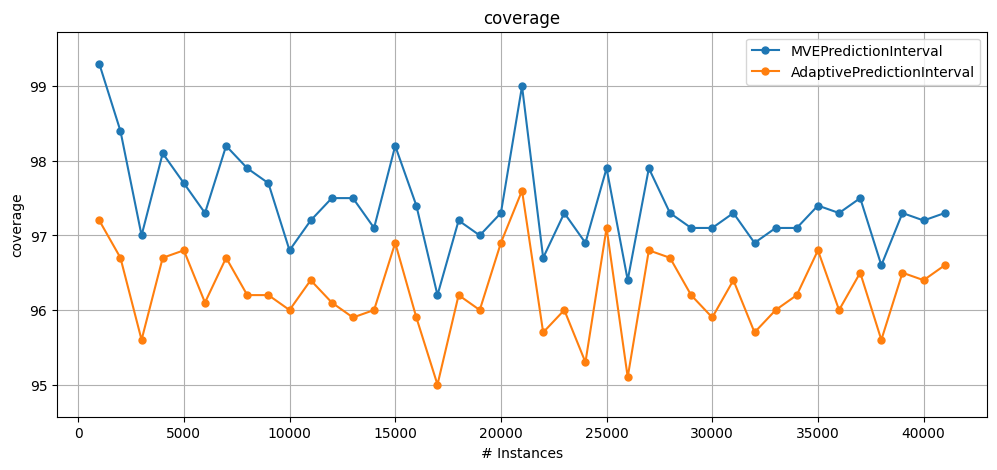

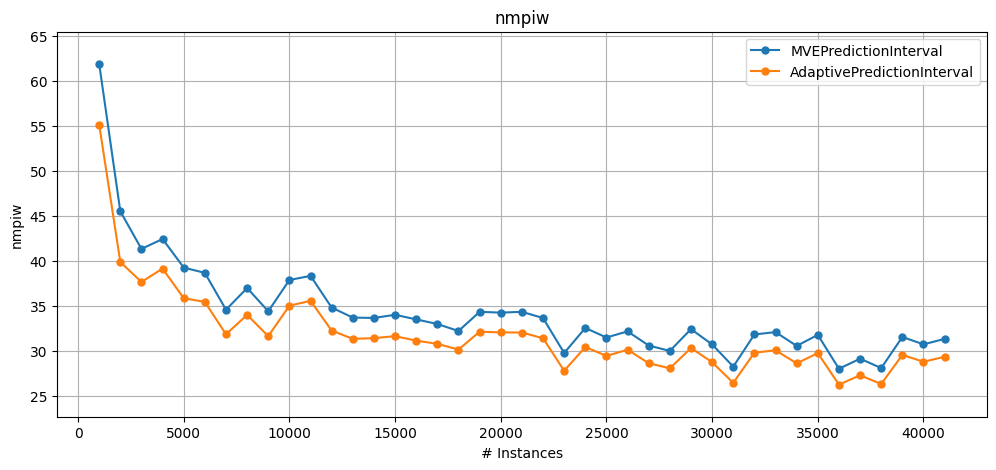

In [7]:
from capymoa.evaluation.visualization import plot_windowed_results

# plot over time comparison
plot_windowed_results(mve_results, adapi_results, metric="coverage")
plot_windowed_results(mve_results, adapi_results, metric="nmpiw")

### 8.6.1 Plotting prediction intervals over time

* We also provide a visualisation tool for plotting prediction intervals over time.
* The function `plot_prediction_interval` can be used to plot the prediction intervals over time.
* This function can take one of two prediction interval results as input.

### 8.6.2 Single result plotting example

* In order to plot the prediction interval over time, we need to have stored the predictions and the ground truth values in the prediction interval results.
* The shaded area represents the prediction interval, while the solid line represents the regressor's predictions.
* The star markers represent the ground truth values that are covered by the intervals.
* On the other hand, the cross markers represent the ground truth values that are outside the intervals. 
* The colors can be adjusted by the `colors` parameter in the function as a list.
* `start` and `end` parameters can be used to specify the range of the plot.
* The `ground truth` and `predictions` can be omitted by setting the `plot_truth` and `plot_predictions` parameters to `False`.

**We have to set `optimise` to `False` to avoid subscribing problems**.

In [ ]:
new_mve_learner = MVE(
    schema=fried_stream.get_schema(),
    base_learner=SOKNL(schema=fried_stream.get_schema(), ensemble_size=10),
)
new_mve_results = prequential_evaluation(
    stream=fried_stream,
    learner=new_mve_learner,
    window_size=1000,
    optimise=False,
    store_predictions=True,
    store_y=True,
)

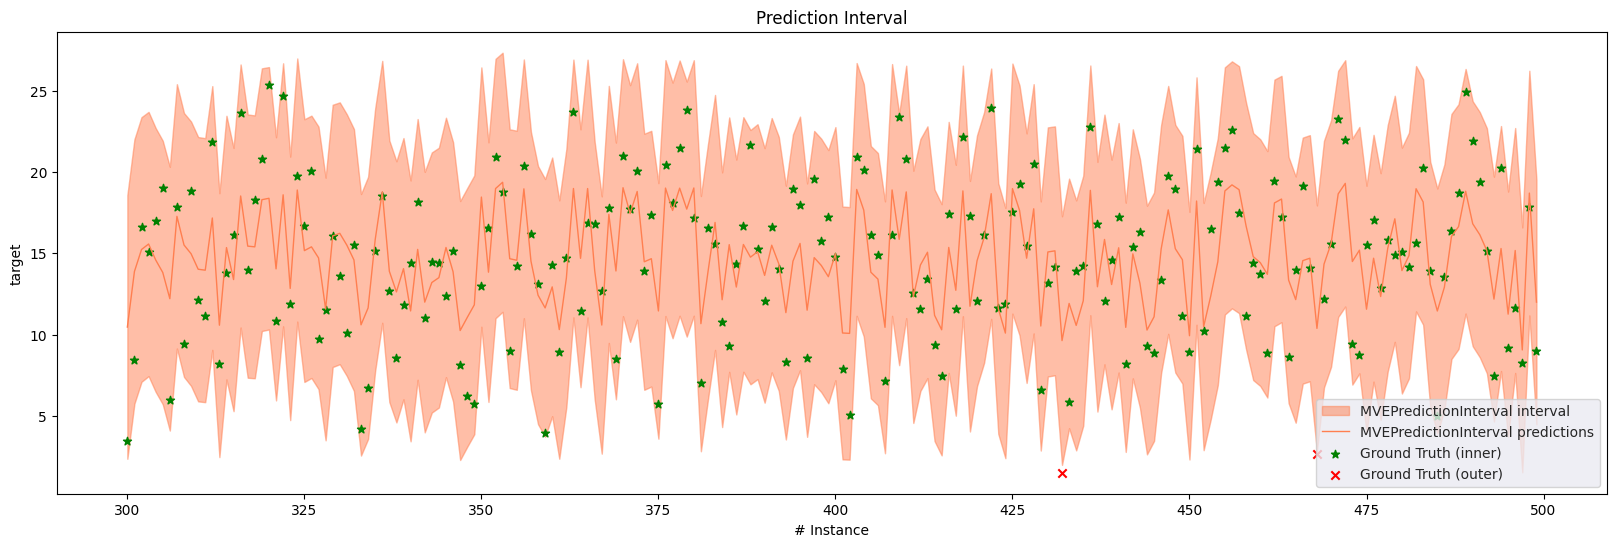

In [9]:
from capymoa.evaluation.visualization import plot_prediction_interval

plot_prediction_interval(new_mve_results, start=300, end=500, colors=["coral"])

### 8.6.3 Two results plotting example

* For comparison purposes, we can also plot two prediction interval results over time.
* We don't offer the ability to take more than two since it makes the plot too messy to read.

In [10]:
# Let's add another results
new_adapi_learner = AdaPI(
    schema=fried_stream.get_schema(),
    base_learner=SOKNL(schema=fried_stream.get_schema(), ensemble_size=10),
    limit=0.001,
)
new_adapi_results = prequential_evaluation(
    stream=fried_stream,
    learner=new_adapi_learner,
    window_size=1000,
    optimise=False,
    store_predictions=True,
    store_y=True,
)

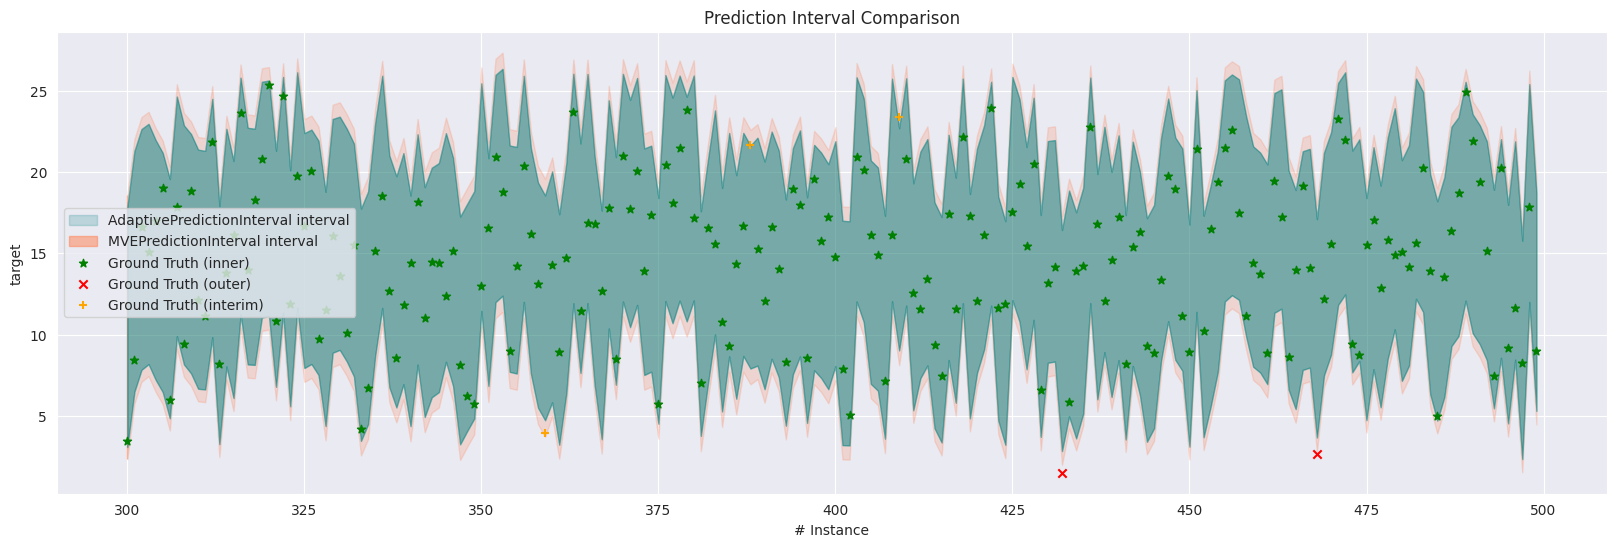

In [11]:
plot_prediction_interval(
    new_mve_results,
    new_adapi_results,
    start=300,
    end=500,
    colors=["coral", "teal"],
    plot_predictions=False,
)

* New plus markers represent the ground truth values that are covered by the narrower but not the wider intervals. 
* The function automatically puts the wider area to the back to make the narrower intervals more visible.